In [ ]:
#! pip install nltk
#! pip install datasets
#! pip install tiktoken
#! pip install spacy
! pip uninstall -y scipy
! pip install scipy==1.12

import nltk
nltk.download('punkt')
nltk.download('wordnet')

In [26]:
import os
import numpy as np
import pandas as pd
import s3fs
import zipfile
import matplotlib.pyplot as plt
from nltk import word_tokenize, sent_tokenize

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
import tiktoken
import nltk

from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import gensim.downloader

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier

from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from spacy.lang.en.stop_words import STOP_WORDS as en_stop

from itertools import chain
from collections import Counter
import json
import re

# Export Dataset

In [3]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

# Lister les challenges
#fs.ls("gvimont/diffusion/hackathon-minarm-2024")

# Lister les fichiers d'un challenge
fs.ls("civel/diffusion/hackathon-minarm-2024/AIVSAI")
PATH_IN = 'civel/diffusion/hackathon-minarm-2024/AIVSAI/hack_train.csv'
fs.download(PATH_IN, 'data/hack_train.csv')

[None]

In [4]:
def load_csv():
    file_path = "data/hack_train.csv"
    return pd.read_csv(filepath_or_buffer=file_path)
df = load_csv()
df

,text,label,src
0,Little disclaimer: this deals with US laws and...,1,cmv_human
1,"Read: Mentally Retarded Downs. See, we've got ...",1,cmv_human
2,"If any of you frequent rbadhistory, there is a...",1,cmv_human
3,"I believe in a flat tax system, where everyone...",1,cmv_human
4,"Edit: Ok guy's, my views have been changed on ...",1,cmv_human
...,...,...,...
56814,We consider the recovery of a source term f (x...,1,sci_gen_human
56815,"Self-supervised learning (SlfSL), aiming at le...",1,sci_gen_human
56816,Recurrent neural networks (RNNs) have achieved...,1,sci_gen_human
56817,Deep reinforcement learning (DRL) is a booming...,1,sci_gen_human


# Clean Dataframe

In [5]:
def clean_dataframe_new(df):
    df = df.drop_duplicates()
    df = df.dropna()
    
    return df
df = clean_dataframe_new(df)
df

,text,label,src
0,Little disclaimer: this deals with US laws and...,1,cmv_human
1,"Read: Mentally Retarded Downs. See, we've got ...",1,cmv_human
2,"If any of you frequent rbadhistory, there is a...",1,cmv_human
3,"I believe in a flat tax system, where everyone...",1,cmv_human
4,"Edit: Ok guy's, my views have been changed on ...",1,cmv_human
...,...,...,...
56814,We consider the recovery of a source term f (x...,1,sci_gen_human
56815,"Self-supervised learning (SlfSL), aiming at le...",1,sci_gen_human
56816,Recurrent neural networks (RNNs) have achieved...,1,sci_gen_human
56817,Deep reinforcement learning (DRL) is a booming...,1,sci_gen_human


# Save Dataset in Onyxia

In [7]:
PATH_OUT = 'misterfacile/diffusion/projet-mongroupe-hackathon/hack_train.csv'
with fs.open(PATH_OUT, 'w') as file_out:
    df.to_csv(file_out, index=False)

# Clean Dataframe

In [30]:
def clean_dataframe(df):
    df = df.drop_duplicates()
    df = df.dropna()

    df['label'] = df['label'].replace({0: 'machine_answer', 1: 'human_answer'})
    return df

# Read From Onyxia

In [31]:
with fs.open(PATH_OUT, mode="r") as file_in:
    df = pd.read_csv(file_in)
    df = clean_dataframe(df)

In [32]:
df.head()

,text,label,src
0,Little disclaimer: this deals with US laws and...,human_answer,cmv_human
1,"Read: Mentally Retarded Downs. See, we've got ...",human_answer,cmv_human
2,"If any of you frequent rbadhistory, there is a...",human_answer,cmv_human
3,"I believe in a flat tax system, where everyone...",human_answer,cmv_human
4,"Edit: Ok guy's, my views have been changed on ...",human_answer,cmv_human


## Tokenizer

In [33]:
def nltk_tokenize(doc: str) -> list[str]:
    return word_tokenize(doc)

def gpt_tokenize(doc: str) -> list:
    enc = tiktoken.encoding_for_model("gpt-4")
    tokens = enc.encode(doc)
    return [str(token) for token in tokens]

### Plus d'outils de tokenization

In [34]:
def tokenize(doc: str, base_tokenizer=word_tokenize, do_lower=False, do_remove_stop_word=False, custom_stop_words=[], do_lemmatize=False) -> tuple[list,list]:
    if do_lower:
        doc = doc.lower()
    list_token = base_tokenizer(doc)

    if do_remove_stop_word:
        stop_words = en_stop | set("-.!?()_;:,'[]$%*/|\\") | {'...'} | {"''"} | {"``"} | set(custom_stop_words) 
        list_token = [token for token in list_token if token not in stop_words]
        
    if do_lemmatize:
        wnl = WordNetLemmatizer()
        list_token = [wnl.lemmatize(t) for t in list_token]

    return list_token

def use_tokenizer(tokenizer, base_tokenizer=word_tokenize):
    return tokenizer

def remove_stop_words(custom_stop_words):
    return custom_stop_words

def add_stop_words(words, custom_stop_words):
    custom_stop_words.extend(words)
    return custom_stop_words

def lower():
    return True

def lemmatize():
    return True

## Statistiques

### Compare the length of the answers between human and machine

In [35]:
def compareLengthAnswer(data) :

    #Collect the length of the answer
    lengthHumanAnswer = data[data['label'] ==  "human_answer"]['text'].apply(len)
    lengthChatGPTAnswer = data[data['label'] ==  "machine_answer"]['text'].apply(len)
    
    # Display the graphic
    plt.figure(figsize=(10, 6))
    plt.hist(lengthHumanAnswer, bins=100, alpha=0.5, label='Human Answers')
    plt.hist(lengthChatGPTAnswer, bins=20, alpha=0.5, label='Machine Answers')
    plt.title('Comparaison de la taille des réponses')
    plt.xlabel('Quantité de caractères par réponse')
    plt.ylabel('Quantité de réponse')
    plt.legend()

    plt.yscale('log')
    plt.xlim(left=0)

    plt.grid(True)
    plt.show()

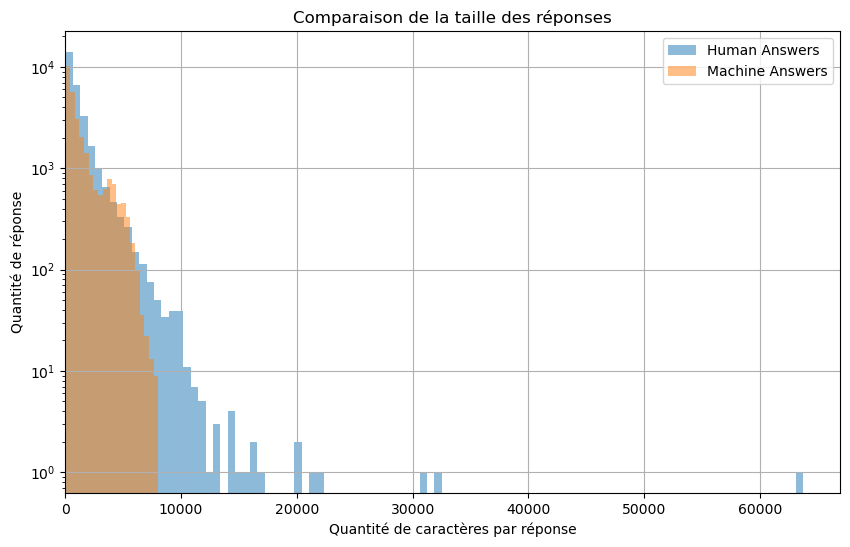

In [36]:
compareLengthAnswer(df)

### Count number of sentences

In [38]:
def count_sentences(text):
    # Utiliser regex pour détecter la fin des phrases avec plus de précision
    sentences = re.split(r'(?<=[.!?])\s+', text)
    # Retourner le nombre de phrases, en s'assurant qu'on ne compte pas les éléments vides
    return len([sentence for sentence in sentences if sentence.strip()])

df_final = df.copy()
# Appliquer la fonction de comptage sur les colonnes des réponses et créer de nouvelles colonnes pour les comptes
df_final['human_sentence_count'] = df_final[df_final['label'] ==  "human_answer"]['text'].apply(count_sentences)
df_final['chatgpt_sentence_count'] = df_final[df_final['label'] ==  "machine_answer"]['text'].apply(count_sentences)

# Grouper par la colonne 'source' et calculer la somme des phrases pour chaque source
grouped = df_final.groupby('src').agg({
    'human_sentence_count': 'sum',
    'chatgpt_sentence_count': 'sum'
}).reset_index()

grouped

,src,human_sentence_count,chatgpt_sentence_count
0,cmv_human,38731.0,0.0
1,cmv_machine_continuation_13B,0.0,3259.0
2,cmv_machine_continuation_30B,0.0,2743.0
3,cmv_machine_continuation_65B,0.0,3087.0
4,cmv_machine_continuation_7B,0.0,3099.0
...,...,...,...
317,yelp_machine_continuation_opt_iml_max_1.3b,0.0,660.0
318,yelp_machine_continuation_t0_11b,0.0,129.0
319,yelp_machine_continuation_t0_3b,0.0,312.0
320,yelp_machine_continuation_text-davinci-002,0.0,1185.0


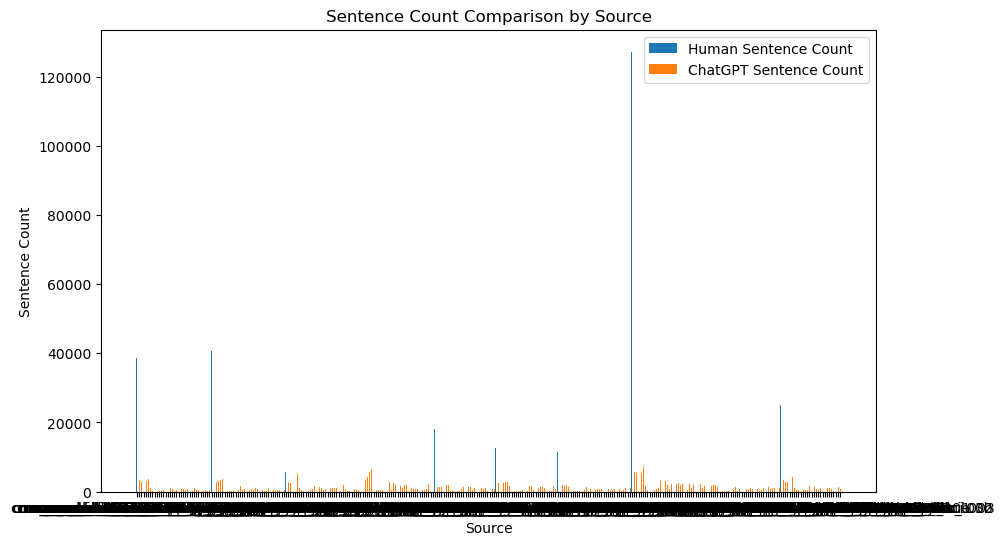

In [41]:
positions = np.arange(len(grouped['src']))

fig, ax = plt.subplots(figsize=(10, 6))
width = 0.35

# Create bars
human_bars = ax.bar(positions - width/2, grouped['human_sentence_count'],width, label='Human Sentence Count')
chatgpt_bars = ax.bar(positions + width/2, grouped['chatgpt_sentence_count'], width, label='ChatGPT Sentence Count')

ax.set_xlabel('Source')
ax.set_ylabel('Sentence Count')
ax.set_title('Sentence Count Comparison by Source')
ax.set_xticks(positions)
ax.set_xticklabels(grouped['src'])
ax.legend()
plt.show()

# CNN Model

In [ ]:
pip install tensorflow

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Concatenate

# Separate text and labels
texts = df['text'].values
labels = df['label'].values

# Tokenization & padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
MAX_LEN = 100

X = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=MAX_LEN)

# Invert label mapping
label_mapping = {0: 1, 1: 0}

if all(label in [0, 1] for label in labels):
    label_mapping = {0: 1, 1: 0}

labels = np.array([label_mapping[label] for label in labels])

# Split data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Model
input_text = Input(shape=(MAX_LEN,), name='input_text')
embed = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128)(input_text)
conv = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(embed)
pool = GlobalMaxPooling1D()(conv)
dense1 = Dense(64, activation='relu')(pool)
output = Dense(1, activation='sigmoid')(dense1)
cnn_model = Model(inputs=input_text, outputs=output)

# Compile
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training
cnn_model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_val, y_val))


In [ ]:
# Evaluation
loss, accuracy = cnn_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Prédire les étiquettes sur les données de test
y_pred = (cnn_model.predict(X_test) > 0.5).astype("int32")

# Générer et imprimer le rapport de classification
print("Classification Report for CNN Model:")
print(classification_report(y_test, y_pred))

# Calculer la précision, le rappel et le score F1 pour les deux classes
precision_class_0 = precision_score(y_test, y_pred, pos_label=0)
recall_class_0 = recall_score(y_test, y_pred, pos_label=0)
f1_class_0 = f1_score(y_test, y_pred, pos_label=0)

precision_class_1 = precision_score(y_test, y_pred, pos_label=1)
recall_class_1 = recall_score(y_test, y_pred, pos_label=1)
f1_class_1 = f1_score(y_test, y_pred, pos_label=1)

print("Metrics for class 0:")
print("Precision:", precision_class_0)
print("Recall:", recall_class_0)
print("F1-score:", f1_class_0)

print("\nMetrics for class 1:")
print("Precision:", precision_class_1)
print("Recall:", recall_class_1)
print("F1-score:", f1_class_1)

# Transformer

In [ ]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dense, Dropout, Flatten

# Tokenization & padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
MAX_LEN = 100
X = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=MAX_LEN)
y = labels

# Split data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Reshape input data
X_train = X_train.reshape(X_train.shape[0], MAX_LEN)
X_val = X_val.reshape(X_val.shape[0], MAX_LEN)
X_test = X_test.reshape(X_test.shape[0], MAX_LEN)

# Transformer Model
vocab_size = len(tokenizer.word_index) + 1
max_len = MAX_LEN

input_layer = Input(shape=(max_len,), name='transformer_input')
embed = Embedding(vocab_size, 128, mask_zero=True)(input_layer)
attention = MultiHeadAttention(num_heads=8, key_dim=64)(embed, embed)
attention = LayerNormalization()(attention + embed)
dense = Dense(64, activation='relu')(attention)
dropout = Dropout(0.1)(dense)
output = Dense(64, activation='relu')(dropout)
output = Flatten()(output)
output = Dense(1, activation='sigmoid')(output)

transformer_model = Model(inputs=input_layer, outputs=output)

# Compile Transformer model
transformer_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train Transformer model
transformer_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

In [ ]:
# Evaluate Transformer model
loss, accuracy = transformer_model.evaluate(X_test, y_test)
print(f'Transformer Test Accuracy: {accuracy * 100:.2f}%')

# Prédire les étiquettes sur les données de test
y_pred = (transformer_model.predict(X_test) > 0.5).astype("int32")

# Générer et imprimer le rapport de classification
print("Classification Report for Transformer Model:")
print(classification_report(y_test, y_pred))

# Calculer la précision, le rappel et le score F1 pour les deux classes
precision_class_0 = precision_score(y_test, y_pred, pos_label=0)
recall_class_0 = recall_score(y_test, y_pred, pos_label=0)
f1_class_0 = f1_score(y_test, y_pred, pos_label=0)

precision_class_1 = precision_score(y_test, y_pred, pos_label=1)
recall_class_1 = recall_score(y_test, y_pred, pos_label=1)
f1_class_1 = f1_score(y_test, y_pred, pos_label=1)

print("Metrics for class 0:")
print("Precision:", precision_class_0)
print("Recall:", recall_class_0)
print("F1-score:", f1_class_0)

print("\nMetrics for class 1:")
print("Precision:", precision_class_1)
print("Recall:", recall_class_1)
print("F1-score:", f1_class_1)